In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
!ls "/content/drive/My Drive/ECG HeartBeat Categorization"


check1.h5  ECG.ipynb  mitbih_test.csv  mitbih_train.csv


In [0]:
import math
import random
import pickle
import itertools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as plt

np.random.seed(42)

import pickle
from sklearn.preprocessing import OneHotEncoder

from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

In [7]:
df = pd.read_csv("/content/drive/My Drive/ECG HeartBeat Categorization/mitbih_train.csv", header=None)
df2 = pd.read_csv("/content/drive/My Drive/ECG HeartBeat Categorization/mitbih_test.csv", header=None)
df = pd.concat([df, df2], axis=0)
df.head()


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


In [9]:
df[187].value_counts()

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: 187, dtype: int64

In [10]:
M = df.values
X = M[:, :-1]
y = M[:, -1].astype(int)
print(X[95005][186])
print(y[9500])




0.0
0


In [11]:
C0 = np.argwhere(y == 0)
print(C0.shape)
print("Hello")
C0 = np.argwhere(y == 0).flatten()
print(C0.shape)
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()


(90589, 1)
Hello
(90589,)


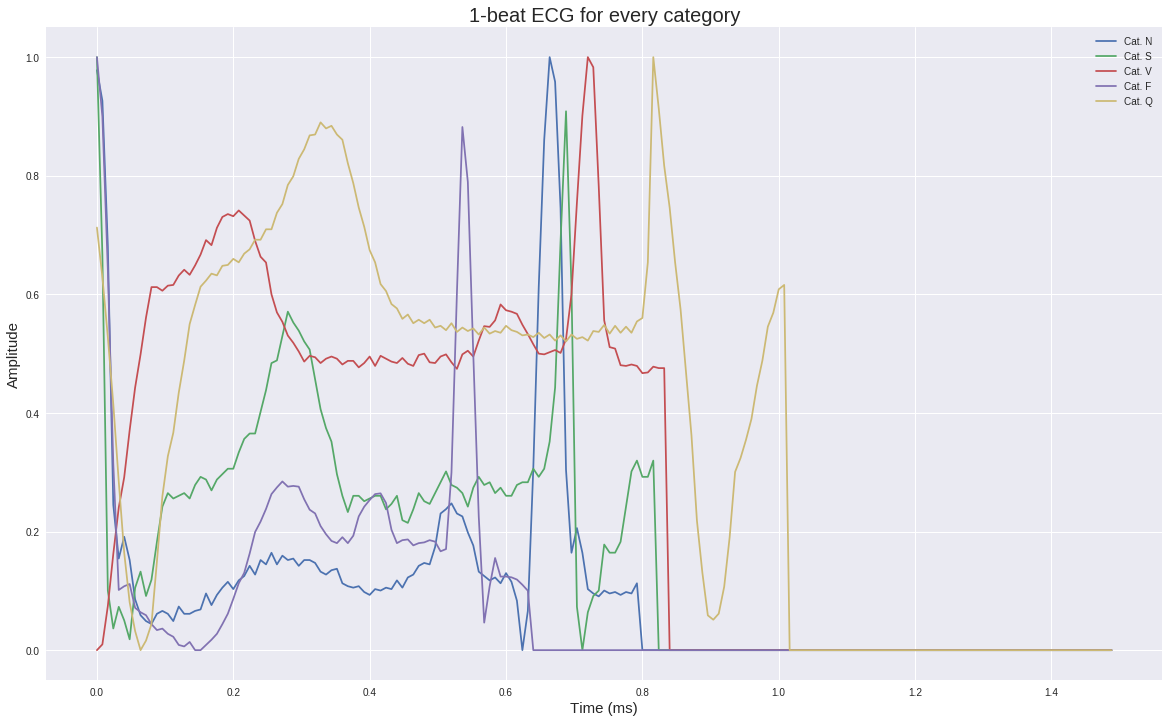

In [12]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][0], label="Cat. N")
plt.plot(x, X[C1, :][0], label="Cat. S")
plt.plot(x, X[C2, :][0], label="Cat. V")
plt.plot(x, X[C3, :][0], label="Cat. F")
plt.plot(x, X[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

In [0]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

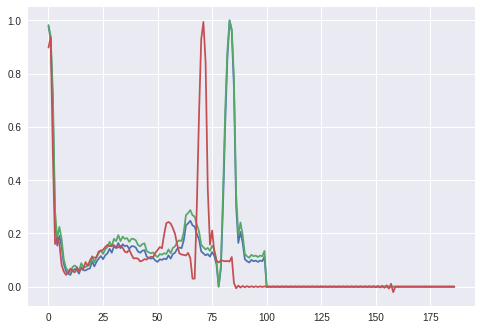

In [14]:
plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.plot(stretch(X[0, :]))
plt.show()

In [0]:
result = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 187)
classe = np.ones(shape=(result.shape[0],), dtype=int)*3
X = np.vstack([X, result])
y = np.hstack([y, classe])

In [0]:
subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

In [0]:
X_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])

X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)


In [0]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [19]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109150, 187, 1)
y_train (109150,)
X_test (4000, 187, 1)
y_test (4000,)


In [20]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [21]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109150, 187, 1)
y_train (109150, 5)
X_test (4000, 187, 1)
y_test (4000, 5)


In [0]:
n_obs, feature, depth = X_train.shape
batch_size = 500

In [0]:
K.clear_session()

inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 187, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 183, 32)      5152        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 183, 32)      0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (

In [0]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

In [0]:
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
filepath=r"/content/drive/My Drive/ECG HeartBeat Categorization/check2.h5"

import keras
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False, mode='max')

In [0]:
history = model.fit(X_train, y_train, 
                    epochs=75, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(X_test, y_test), 
                    callbacks=[checkpoint, lrate])

Train on 105938 samples, validate on 4000 samples
Epoch 1/75
 - 12s - loss: 0.3252 - acc: 0.9072 - val_loss: 1.6794 - val_acc: 0.5932

Epoch 00001: val_acc improved from -inf to 0.59325, saving model to /content/drive/My Drive/ECG HeartBeat Categorization/check1.h5
Epoch 2/75
 - 7s - loss: 0.1205 - acc: 0.9680 - val_loss: 1.1122 - val_acc: 0.6680

Epoch 00002: val_acc improved from 0.59325 to 0.66800, saving model to /content/drive/My Drive/ECG HeartBeat Categorization/check1.h5
Epoch 3/75
 - 7s - loss: 0.0887 - acc: 0.9767 - val_loss: 1.0413 - val_acc: 0.7025

Epoch 00003: val_acc improved from 0.66800 to 0.70250, saving model to /content/drive/My Drive/ECG HeartBeat Categorization/check1.h5
Epoch 4/75
 - 7s - loss: 0.0724 - acc: 0.9807 - val_loss: 0.5959 - val_acc: 0.8135

Epoch 00004: val_acc improved from 0.70250 to 0.81350, saving model to /content/drive/My Drive/ECG HeartBeat Categorization/check1.h5
Epoch 5/75
 - 7s - loss: 0.0637 - acc: 0.9828 - val_loss: 0.5106 - val_acc: 0.84

In [0]:
from keras.models import load_model
new=load_model('/content/drive/My Drive/ECG HeartBeat Categorization/check1.h5')




In [0]:
from sklearn import manifold
#P1 = enc_l1.predict(X_strint)
#tsne = manifold.TSNE(n_components=2,init='pca')
#P1_tsne = tsne.fit_transform(P1)
#plt.colorbar(sp1)
#plt.legend(prop={'size':6})
#plt.title('t-SNE embedding: deep network - layer3')
#plt.savefig('t-SNE_deep_layer3.png')
P1=new.predict(X_train)
tsne = manifold.TSNE(n_components=2,init='pca')
P1_tsne = tsne.fit_transform(P1)

In [28]:
print(P1_tsne.shape)
print(P1_tsne[1])

(109150, 2)
[19.228035 25.753178]


Text(0.5, 1.0, 't-SNE embedding: deep network - layer3')

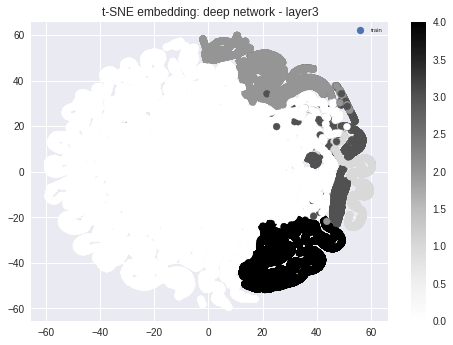

In [58]:
#sp1 = plt.scatter(P3_tsne_train[:-50,0],P3_tsne_train[:-50,1],c=y1[:-50],label='train')
#c  = b.reshape((3,))  
y2_trial=np.argmax(y_train,axis=1)
y_trial=[] 
for i in range(109150):
   y_trial.append(y2_trial[i,0])

#print(y_trial.shape)

#print(P1_tsne[:,0].shape)
colors = np.random.rand(109150)
sp1=plt.scatter(P1_tsne[:,0],P1_tsne[:,1],c=y_trial,label='train')
plt.colorbar(sp1)
plt.legend(prop={'size':6})
plt.title('t-SNE embedding: deep network - layer3')
#plt.savefig('t-SNE_deep_layer3.png')